# Clean up the full train and test datasets

In [51]:
%matplotlib inline

In [86]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import pprint
from IPython.display import display, HTML
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn import model_selection

## Load Data

In [53]:
train_file = "../data/train.csv"
train_orig = pd.read_csv(train_file, index_col=0)
train = train_orig.copy()

test_file = "../data/test.csv"
test_orig = pd.read_csv(test_file, index_col=0)
test = test_orig.copy()


## Clean the data

### Some manual data cleaning based on experience working with dataset.

In [54]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [55]:
# There is only one train record that isn't "Utilities=AllPub"...
train.drop(['Utilities'], inplace=True, axis=1)
test.drop(['Utilities'], inplace=True, axis=1)

In [56]:
# There is a single MSSubClass==150 in test and none in train.
# From the description, we know:
#       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#       150	1-1/2 STORY PUD - ALL AGES
#       160	2-STORY PUD - 1946 & NEWER
# 120 is more common than 150, and although 1.5 story makes sense to be worth more than 1 story, all ages might be worth less...
# Sort of arbitrarily set 150->120
train.loc[train['MSSubClass'] == 150, 'MSSubClass'] = 120 # Just for symmetry - this doesn't actually match any records
test.loc[test['MSSubClass'] == 150, 'MSSubClass'] = 120

### Impute the numeric data

In [57]:
cols_numeric = train.select_dtypes(include=[np.number]).columns.tolist()

# Don't want to impute on sale price...
cols_numeric.remove('SalePrice')

# Look down each column and replace missing values with the median of that column 
# (since we're using integers, median seemed to make more sense)
# Imputer is trained on the training data, NOT the test data!
imp_numeric = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_numeric.fit(train[cols_numeric])

# train_imputed = train.copy()
train[cols_numeric] = imp_numeric.transform(train[cols_numeric])
# test_imputed  = test.copy()
test[cols_numeric]  = imp_numeric.transform(test[cols_numeric])

### Handle the non-numeric columns

### sklearn has OneHotEncoder, but pandas now has a built in get_dummies()
see:
* http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/
* http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html

Make an imputer for categoricals.  Inherrit the TransformerMixin for .fit and .transform

In [58]:
class CategoricalImputer(TransformerMixin):
    
    def __init__(self):
        """Impute missing categorical values by replacing them with the most common value.
        
        Adapted from http://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
        """
        
    def fit(self, X, y=None):
        # Make a pd.Series that has a fill value for each column (use np.nan for anything non-categorical)
        self.fill = pd.Series([X[c].value_counts().index[0] if X[c].dtype == np.dtype('O') else np.nan for c in X ], index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
# Example:

# data = [
#     ['a', 1, 2],
#     ['b', 1, 1],
#     ['b', 2, 2],
#     [np.nan, np.nan, np.nan]
# ]

# X = pd.DataFrame(data)
# xt = CategoricalImputer().fit_transform(X)

# print('before...')
# print(X)
# print('after...')
# print(xt)

Get the non-numeric columns


In [59]:
cols_non_numeric = train.select_dtypes(exclude=[np.number]).columns.tolist()


Many columns have nan, but from the description several use nan as a value.  Only fix the ones that shouldn't have nan

In [60]:
# Make lists for datasets that could intentionally have nan (typically they mean "I don't have this feature")
# Any record with a nan in a basement category should have a nan in all basement categories.  Same with garage.  
# Groupd those to check
nan_bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure']
nan_garage = ['GarageType', 'GarageQual', 'GarageFinish', 'GarageCond']
nan_intentional = ['Alley', 
                   'FireplaceQu', 
                   'PoolQC', 'Fence', 'MiscFeature',] + nan_bsmt + nan_garage

# Get the other nan's (this would have been easier to just type the unintentional ones, but I was already done listing the intentionals..)
# Need to get nan from both train and test.  Get them separately then combine by using sets
nan_unintentional_train = set([train[cols_non_numeric].iloc[:,x].name for x in pd.isnull(train[cols_non_numeric]).any().nonzero()[0] if train[cols_non_numeric].iloc[:,x].name not in nan_intentional ])
nan_unintentional_test = set([test[cols_non_numeric].iloc[:,x].name for x in pd.isnull(test[cols_non_numeric]).any().nonzero()[0] if test[cols_non_numeric].iloc[:,x].name not in nan_intentional ])
nan_unintentional = list(nan_unintentional_train) + list(nan_unintentional_test-nan_unintentional_train)

nan_rows_train = pd.isnull(train[nan_unintentional]).any(1).nonzero()[0]
nan_rows_train_byId = train.index[nan_rows_train]
nan_rows_test = pd.isnull(test[nan_unintentional]).any(1).nonzero()[0]
nan_rows_test_byId = test.index[nan_rows_test]

imp_categorical = CategoricalImputer()
imp_categorical.fit(train[nan_unintentional])
# train_imputed_categorical = train.copy()
train[nan_unintentional] = imp_categorical.transform(train[nan_unintentional])

# And same for test
test[nan_unintentional] = imp_categorical.transform(test[nan_unintentional])

# Predict using Categoricals

## Simple prediction to see if it is working...

First fit a simple linear regression model relating OverallQual (which is a 1-10 numeric feature) to SalePrice

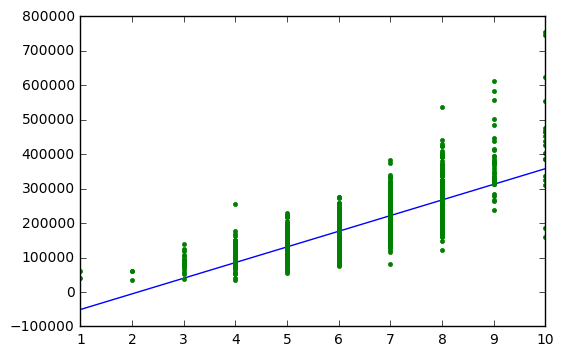

In [61]:
estimator = linear_model.LinearRegression(normalize=True)
estimator.fit(train[['OverallQual']], train['SalePrice'])

x = np.linspace(1,10,10)
dfx = pd.DataFrame(data=x, columns=['OverallQual'])
plt.plot(x, estimator.predict(dfx), '-')
plt.plot(train['OverallQual'], train['SalePrice'], '.')

Now regress by pretending OverallQual is categorical (which it sort of is, it was just represented using numbers).  Use one-hot method to translate "categorical" to boolean features

Index(['OverallQual_2.0', 'OverallQual_3.0', 'OverallQual_4.0',
       'OverallQual_5.0', 'OverallQual_6.0', 'OverallQual_7.0',
       'OverallQual_8.0', 'OverallQual_9.0', 'OverallQual_10.0'],
      dtype='object')


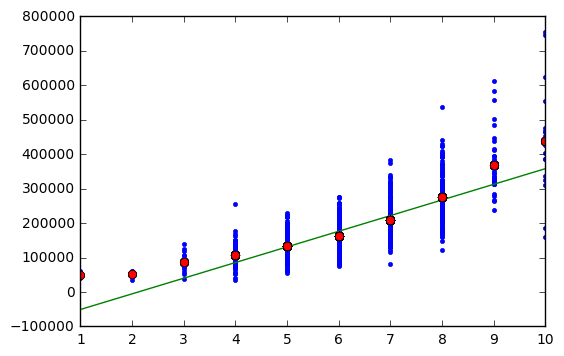

In [62]:
train_simple_OQ = pd.get_dummies(train[['OverallQual']], columns=['OverallQual'])

# Leave one out as you need k-1 indicators for k total results (think of how you need one boolean indicator to represent two results)
features = train_simple_OQ.columns[1::]
print(features)
m = linear_model.LinearRegression(normalize=True) # Does normalize do anything here?
m.fit(train_simple_OQ[features], train['SalePrice'])

# This is overkill on the plotting.  I could just make a very simple identity matrix to plot all these predictions.
# ...but I'm lazy..
plt.plot(train['OverallQual'], train['SalePrice'], '.')
plt.plot(x, estimator.predict(dfx), '-')
plt.plot(train['OverallQual'], m.predict(train_simple_OQ[features]), 'o')

Looks even better than the linear regression on the numerics!  ...Although it has more features...

Investigating the model we get

In [63]:
print(m.intercept_)
list(zip(features, m.coef_))

50150.0


[('OverallQual_2.0', 1620.3333333350231),
 ('OverallQual_3.0', 37323.750000001535),
 ('OverallQual_4.0', 58270.655172415318),
 ('OverallQual_5.0', 83373.347607054005),
 ('OverallQual_6.0', 111453.03475935977),
 ('OverallQual_7.0', 157566.42319749325),
 ('OverallQual_8.0', 224585.53571428699),
 ('OverallQual_9.0', 317363.02325581585),
 ('OverallQual_10.0', 388438.38888889045)]

Ok this makes sense.  So having a quality of say 8 adds $225000 to your house

Note: If we had left OverallQual_10 out, we'd instead have a very high intercept and lots of negative values

## Slightly more advanced fit: sqft + OverallQual

### Make New Features

In [188]:
def feat_eng_polys(df, feat, pwrs, inplace=True):
    """
    Given a dataframe and a feature, return a new (add to existing?) dataframe new features that are the pwrs'th power of the feature.
    
    NOTE: inplace=True isn't entirely inplace.  It was giving me the "A value is trying to be set on a copy of a slice from a DataFrame" error.
    I couldn't figure out why it was happening (or whether it was a false positive), so
    instead i've just changed this to make df_new=df.copy() to work around it.
    
    :param pwrs:
        NOT IMPLEMENTED If pwrs=int, return all powers from 1 to that number.
        NOT IMPLEMENTED If pwrs=float, return that power.
        If pwrs=iterable, return the powers included in pwrs
    """
    f_new = []
    if inplace is not True:
        df_new = pd.DataFrame(index=df.index)
    else:
        df_new = df.copy()

    for p in pwrs:
        f_new.append('{:s}_{:s}'.format(feat, str(p)))
        df_new.loc[:, f_new[-1]] = df.loc[:, feat] ** p

    # Does it matter if this gets returned when doing inplace=True?
    return df_new, f_new

In [65]:
def get_RSS(d1, d2):
    """Return the sum of the square of the errors between two datasets, a measure of total error."""
    npa1 = np.asarray(d1)
    npa2 = np.asarray(d2)
    if npa1.shape != npa2.shape:
        raise ValueError("Found arrays of shape {} and {} - shape of arrays must be the same.".format(npa1.shape, npa2.shape))
    return ((np.asarray(d1) - np.asarray(d2)) ** 2).sum()
def get_RMS(d1, d2):
    """Return the RMS or standard deviation of error between two datasets, a measure of typical error."""
    npa1 = np.asarray(d1)
    npa2 = np.asarray(d2)
    if npa1.shape != npa2.shape:
        raise ValueError("Found arrays of shape {} and {} - shape of arrays must be the same.".format(npa1.shape, npa2.shape))
    return np.sqrt(((np.asarray(d1) - np.asarray(d2)) ** 2).mean())


Add new features
* TotLivSF
* TotLivSF^N
* One-hot of OverallQual

In [66]:
# Copies here are inefficient but useful for debugging...
data = {'train': train.copy(),
        'test': test.copy()}

cat_features = ['OverallQual']

for k in data.keys():
    # Make Total Living Square Footage
    data[k].loc[:, 'TotLivSF'] = data[k]['GrLivArea'] + data[k]['BsmtFinSF1'] + data[k]['BsmtFinSF2']
    # And sqrt of that
#     data[k][:, 'TotLivSF_sqrt'] = np.sqrt(data[k]['TotLivSF'])
    # And 2nd to 5th power
    data[k], f_new_poly  = feat_eng_polys(data[k], 'TotLivSF', range(2,6), inplace=True)
    
    # Add one-hot categoricals
    # Not sure if this is the best way to get the features, but using a temp variable to store the new features.
    # Could also get a set of data[k].columns before and after and take the difference
    temp =  pd.get_dummies(data[k][cat_features], columns=cat_features)
    f_new_cat = list(temp.columns)
    data[k] = pd.concat([data[k], temp], axis=1)
    
# Make a features list including the new polys and all the categoricals but one
features = ['TotLivSF'] + f_new_poly + f_new_cat[1:]
print("Features for fitting: {0}".format(features))


Features for fitting: ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5', 'OverallQual_2.0', 'OverallQual_3.0', 'OverallQual_4.0', 'OverallQual_5.0', 'OverallQual_6.0', 'OverallQual_7.0', 'OverallQual_8.0', 'OverallQual_9.0', 'OverallQual_10.0']


### Filter outliers (like in the previous sqft only case)

Training data:


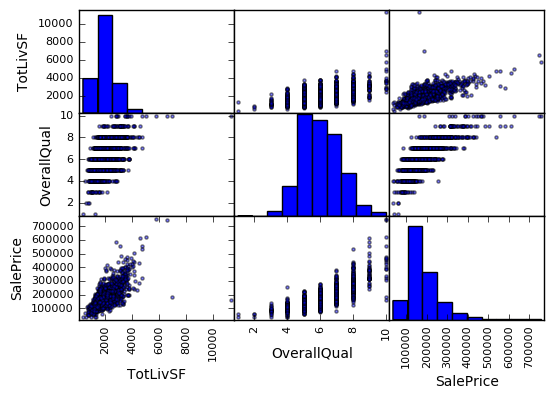

Test data:


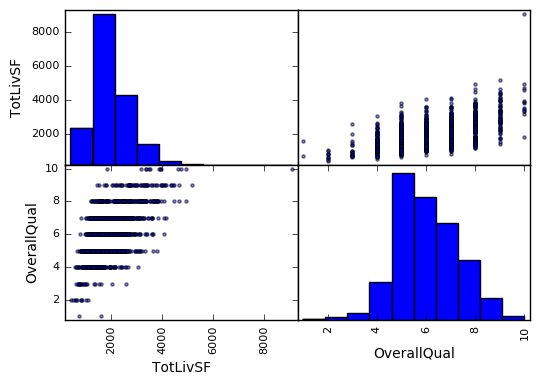

In [67]:
# View the univariate and multivariate interactions for the data using a scatter_matrix
print("Training data:")
scatter_matrix(data['train'][['TotLivSF', 'OverallQual', 'SalePrice']])
plt.show()
print("Test data:")
scatter_matrix(data['test'][['TotLivSF', 'OverallQual']])
plt.show()


From this it looks like the OverallQual is relatively gaussian, and the TotLivSF is also except for a few outliers.  

Let's try to quantify the outliers a little more rigorously.

In [68]:
def outliers_numerical(data, m=2.):
    """Return a boolean array of outliers given numerical data.
    
    Outliers are assessed given:
      m > (x-median(X)) / median(x-median(x))
    if their median(x-median(x)) != 0,
    eg: multiples of the typical distance from the median.
    
    If median(x-median(x)) == 0, mean(x-median(x)) is used as the normalizer:
      m > (x-median(X)) / mean(x-median(x))
    """
    d = np.abs(np.asarray(data) - np.median(np.asarray(data)))
    # Use median if possible, but if median comes out 0 then use mean as a fallback
    mdev = np.median(d)
    s = d/mdev if mdev else d/np.mean(d)
    return ~(s<m)

For the train and test data, quantify how many data points would be considered outliers given different values of m

In [69]:
print("{:>3s}  {:9s} {:9s}".format('m', 'TotLivSF', 'OvrlCond'))
print("{:3s}  {:4s} {:4s} {:4s} {:4s}".format('', 'Trn', 'Test', 'Trn', 'Test'))
for i in range(0,10):
    sf = []
    oc = []
    for ds in ['train', 'test']:
#         print(outliers_numerical(data[ds]['TotLivSF'], i))
#         print(outliers_numerical(data[ds]['OverallCond'], i))
        sf.append(outliers_numerical(data[ds]['TotLivSF'], i).sum())
        oc.append(outliers_numerical(data[ds]['OverallQual'], i).sum())
    
    print("{:3d}: {:4d} {:4d} {:4d} {:4d}".format(i, sf[0], sf[1], oc[0], oc[1]))

  m  TotLivSF  OvrlCond 
     Trn  Test Trn  Test
  0: 1460 1459 1460 1459
  1:  733  730 1086 1102
  2:  314  296  370  393
  3:  119  125   86  109
  4:   51   61   23   25
  5:   23   26    2    2
  6:   11   13    0    0
  7:    5    4    0    0
  8:    4    2    0    0
  9:    4    1    0    0


Not sure where to draw the line here...  Would this be the sort of thing we could examine on a train/validation data set split?

Arbitrarily, let's say anything more than m=7 is an outlier. To visualize:

TotLivSF
5
OverallQual
0


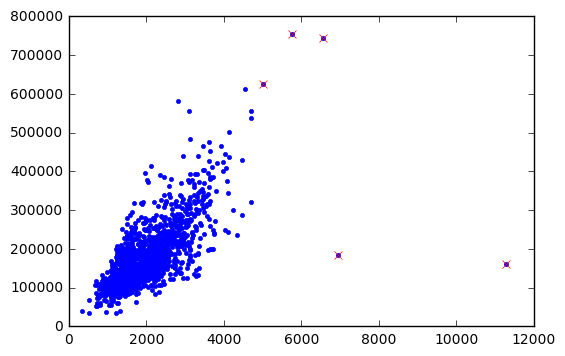

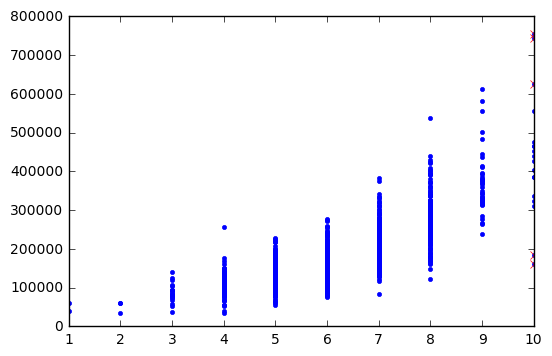

In [70]:
m = 7
mask = np.array([False] * len(data['train'].index))
features = ['TotLivSF', 'OverallQual']
for f in features:
    print(f)
    print(outliers_numerical(data['train'][f], m).sum())
    mask = (mask) | outliers_numerical(data['train'][f], m)

# Not sure why, but dataframe.plot wont take my style specifications...
# ax = data['train'].plot(x='TotLivSF', y='SalePrice', kind='scatter')
# data['train'].loc[1000:,:].plot(x='TotLivSF', y='SalePrice', kind='scatter', style='x')
# data['train'].hist(column='TotLivSF')
# Go straight to the source instead!
plt.plot(data['train']['TotLivSF'], data['train']['SalePrice'], 'b.')
plt.plot(data['train'].loc[mask, 'TotLivSF'], data['train'].loc[mask, 'SalePrice'], 'rx')
plt.show()
plt.plot(data['train']['OverallQual'], data['train']['SalePrice'], 'b.')
plt.plot(data['train'].loc[mask, 'OverallQual'], data['train'].loc[mask, 'SalePrice'], 'rx')
plt.show()

Other ideas for filtering:
http://machinelearningmastery.com/how-to-identify-outliers-in-your-data/

Some examples
* Nearest neighbor
* Error from linear regression
* ...

Now filter out the outliers in the training data

In [71]:
print("Count before dropping outliers: {}".format(len(data['train'].index)))
data['train'].drop(data['train'].index[mask], inplace=True)
print("Count after dropping outliers: {}".format(len(data['train'].index)))

Count before dropping outliers: 1460
Count after dropping outliers: 1455


### Train a RidgeCV model using these features

In [72]:
alphas = np.logspace(-6,5,12)
m = linear_model.RidgeCV(normalize=True, alphas=alphas)
m.fit(data['train'][features], data['train'][['SalePrice']])

RidgeCV(alphas=array([  1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=True,
    scoring=None, store_cv_values=False)

In [73]:
print(m.coef_)

[[    47.5423634   31636.98885746]]


In [74]:
predictions = m.predict(data['train'][features])
RMS = get_RMS(data['train'][['SalePrice']], predictions)
RSS = get_RSS(data['train'][['SalePrice']], predictions)
print("RSS={:8e}, RMS={:8.2f}".format(RSS, RMS))

RSS=1.807636e+12, RMS=35247.15


This RSS/RMS gives me a measure of the fit, but doesn't really tell me how good the actual prediction is (I could be over fitting the training data).  A bit better measure here might be a cross validation score (do this but through cross validation), or by using a training/validation split in the data.

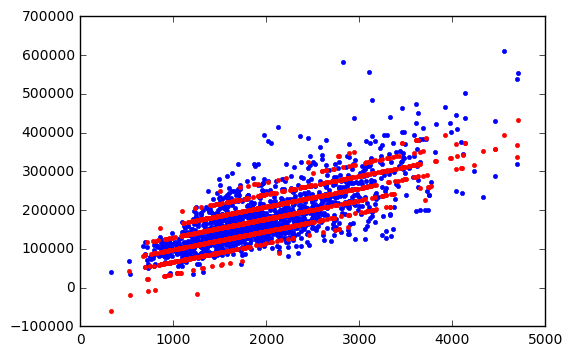

In [75]:
plt.plot(data['train']['TotLivSF'], data['train']['SalePrice'], 'b.')
plt.plot(data['train']['TotLivSF'], m.predict(data['train'][features]), 'r.')

I should really check this against the original data with outliers and see what it does, too.

### Apply RidgeCV model to predict test results

In [76]:
predictions_test = pd.DataFrame(m.predict(data['test'][features]), columns=['SalePrice'], index=data['test'].index, )


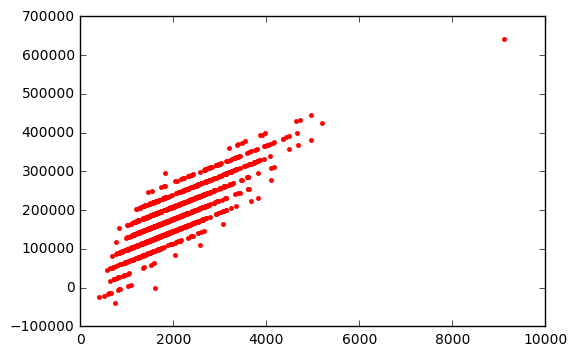

In [77]:
plt.plot(data['test']['TotLivSF'], predictions_test['SalePrice'], 'r.')

We still have the super outlier...  But this time it is positive at least.  Don't bother fudging it.

Notes:
* This seems to improve on the sqft-only model!  Not by a ton, but still something.
* FYI, if I skip the filtering of the data above, this gets a slightly worse score on the test data (although that's not really a good way of checking that sort of thing)

In [78]:
# Commented out so I dont keep overwriting the thing...
# predictions_test.to_csv('test_predictions_sqft_OverallQual_with-outlier-filter.csv')
# -> Private score: 0.20735.  Public score: 0.17652

## Next Steps
* Add more features (all features?).  
    * Get this to work on a single regressor.  Do I still have negatives?  Make automated check?  Wrapper for predicting and returning as df?
    * Extend to several regressors
* Run RidgeCV, then RidgeCV in feature selection.  Compare performance and which features they choose.  
* Add LassoCV, then take LassoCV's selected features and fit them with RidgeCV.  How does that compare to feature selection's RidgeCV?


* Redo everything but normalize the data first.  
    * Does this improve results?
    * Does this make LinearRegression work with feature selection?


* Get SVR to work.

## Notes for later
* Systematic filtering (see bookmarks, and look at the sklearn feature_selection man page)
* Systematic skewness adjustment (see bookmarks)
* Use sklearn.preprocessing.PolynomialFeatures instead of my own (?)

## Formalize things a bit more

Make scalable code that can process and regress on more features

In [202]:
# Feature-generating code

def feature_TotLivSF(df):
    return df['GrLivArea'] + df['BsmtFinSF1'] + df['BsmtFinSF2']

In [203]:
# Original base features to use (categorical and numerical separate?)
features = {'num': ["LotArea", "FullBath", "OverallQual"], #now using OverallQual as a number!
            'cat': ["MSSubClass", "Neighborhood"],
           }

# Working copy of data
# data = {'train': train.loc[:, features['num'] + features['cat'] + ['SalePrice']].copy(),
#         'test': test.loc[:, features['num'] + features['cat']].copy()}
data = {'train': train.copy(),
        'test': test.copy()}


# Containers for added features
features_new = {'num': [],
                'cat': [],
               }

In [204]:
# Add TotLivSF numeric feature
def feature_TotLivSF(df):
    return df['GrLivArea'] + df['BsmtFinSF1'] + df['BsmtFinSF2']

for k,d in data.items():
    d.loc[:, 'TotLivSF'] = feature_TotLivSF(d)
features['num'].append('TotLivSF')

print("All base features:")
pprint.pprint(features)

All base features:
{'cat': ['MSSubClass', 'Neighborhood'],
 'num': ['LotArea', 'FullBath', 'OverallQual', 'TotLivSF']}


Training data:


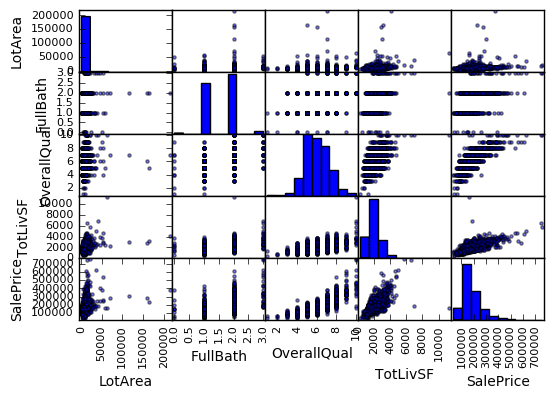

Test data:


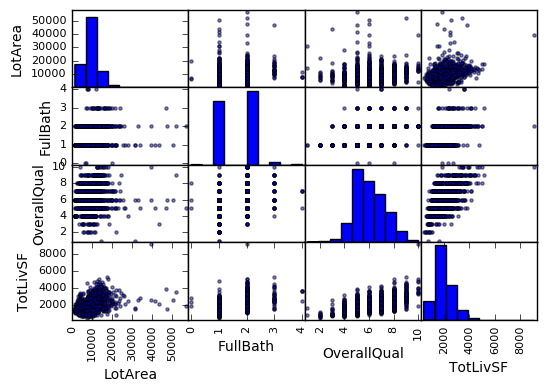

In [205]:
# Filter outliers from numerical data

# Visualize the univariate and multivariate interactions for numeric data using a scatter_matrix
print("Training data:")
scatter_matrix(data['train'][features['num'] + ['SalePrice']])
plt.show()
print("Test data:")
scatter_matrix(data['test'][features['num']])
plt.show()


Feature LotArea has 55 outliers


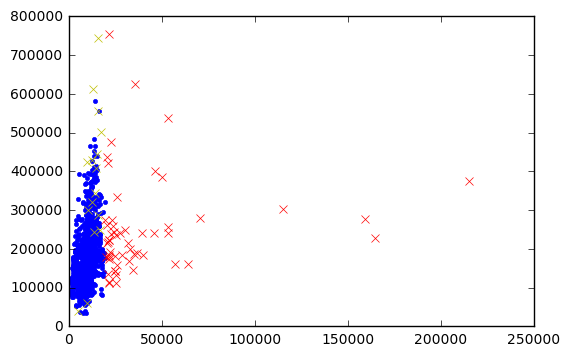

Feature FullBath has 0 outliers


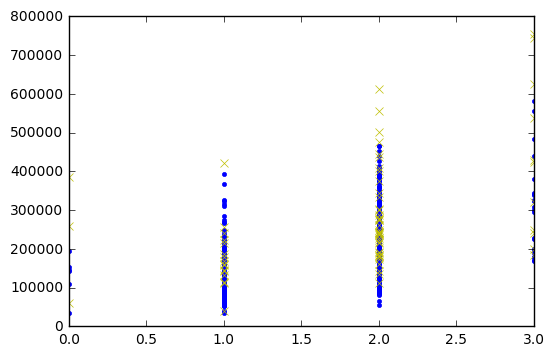

Feature OverallQual has 2 outliers


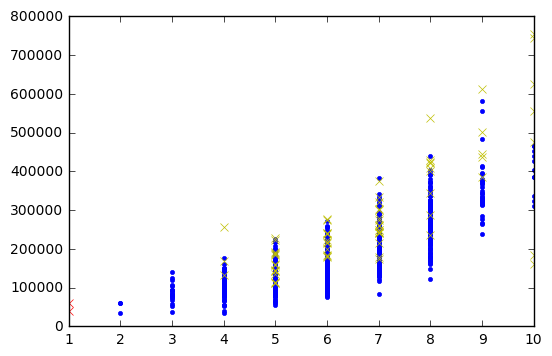

Feature TotLivSF has 23 outliers


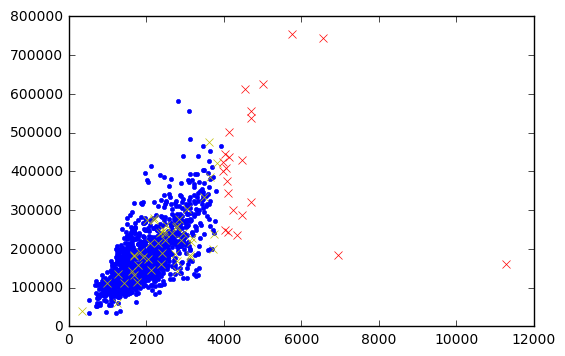

In [206]:
# Lets say more than 5*median away is an outlier...
m = 5
data_to_filter = ['train']

for k in data_to_filter:
    total_mask = np.array([False] * len(data[k].index))
    masks = {}
    
    # Filter only numerical features
    # Calculate masks
    for f in features['num']:
        masks[f] = outliers_numerical(data[k][f], m)
        total_mask = (total_mask) | (masks[f])

    # Visualize filtered data
    for f in features['num']:
        print("Feature {} has {} outliers".format(f, masks[f].sum()))
        
        good = ~total_mask
        bad_here = masks[f]
        bad_elsewhere = total_mask & ~bad_here
        
        plt.plot(data[k].loc[good, f], data[k].loc[good, 'SalePrice'], 'b.')
        plt.plot(data[k].loc[bad_here, f], data[k].loc[bad_here, 'SalePrice'], 'rx')
        plt.plot(data[k].loc[bad_elsewhere, f], data[k].loc[bad_elsewhere, 'SalePrice'], 'yx')
        plt.show()
        
    data[k] = data[k].loc[good, :]

### Make new derived features (powers, sqrt, one-hot) 

**Notes:**
* First attempt here found that the train and test databases don't always have the entire set of categorical responses (eg: There is a single test MSSubClass=150 in test and none in train).  
* Currently avoiding this by addressing these inconsistencies in manual munging, but could also do some automated checks here

In [207]:
# Number of powers
p = 6
f_new = {'num': set(),
         'cat': set(),
        }

f_new['cat'] = {k:set() for k in data.keys()}

for f in features['num']:
    for k in data.keys():
        # Polynomials
        data[k], f_new_poly = feat_eng_polys(data[k], f, range(2, p), inplace=True)
        f_new['num'].update(f_new_poly)
        
        # Sqrt
        data[k].loc[:, f + '_0.5'] = np.sqrt(data[k].loc[:, f])
        f_new['num'].add(f + '_0.5')

# One-hot categoricals
for k in data.keys():
    for f in features['cat']:
        # Not sure if this is the best way to get the features, but using a temp variable to store the new features.
        # Could also get a set of data[k].columns before and after and take the difference
        temp =  pd.get_dummies(data[k][[f]], columns=[f])
        # Exclude the first column (redundant)
        f_new['cat'][k].update(list(temp.columns)[1:])
        data[k] = pd.concat([data[k], temp], axis=1)
        
# Update feature lists
features['num'] = sorted(features['num'] + list(f_new['num']))
print("Numerical features:")
print(features['num'])
# Remove the base names of the categorical features
features['cat'] = sorted(list(f_new['cat'][k]))
print("Categorical features:")
print(features['cat'])

Numerical features:
['FullBath', 'FullBath_0.5', 'FullBath_2', 'FullBath_3', 'FullBath_4', 'FullBath_5', 'LotArea', 'LotArea_0.5', 'LotArea_2', 'LotArea_3', 'LotArea_4', 'LotArea_5', 'OverallQual', 'OverallQual_0.5', 'OverallQual_2', 'OverallQual_3', 'OverallQual_4', 'OverallQual_5', 'TotLivSF', 'TotLivSF_0.5', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']
Categorical features:
['MSSubClass_120.0', 'MSSubClass_160.0', 'MSSubClass_180.0', 'MSSubClass_190.0', 'MSSubClass_30.0', 'MSSubClass_40.0', 'MSSubClass_45.0', 'MSSubClass_50.0', 'MSSubClass_60.0', 'MSSubClass_70.0', 'MSSubClass_75.0', 'MSSubClass_80.0', 'MSSubClass_85.0', 'MSSubClass_90.0', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighb

### Split the training data into training and validation sets to compare models

Still always confused when to do this and when not to.  If I use cross-validation, do I still need this?  I guess if I do CV and don't have this split, I have no way of knowing my typical error (as CV doesn't really give that)?

In [208]:
validation_size = 0.2
seed = 7
X_train, X_validation = model_selection.train_test_split(data['train'], test_size=validation_size, random_state=seed)
data['train'] = X_train
data['valid'] = X_validation

### Regress using several models

In [209]:
features_all = features['cat'] + features['num']

models = {
    'Linear': linear_model.LinearRegression(normalize=True),
    'Lasso': linear_model.Lasso(normalize=True, max_iter=10000),
    'LassoCV': linear_model.LassoCV(normalize=True, max_iter=10000, alphas=np.logspace(0, 3, 3*13+1)),
    'Ridge': linear_model.Ridge(normalize=True),
    'RidgeCV': linear_model.RidgeCV(normalize=True),
#     'SVM-Linear':   SVR(kernel='linear', C=1e3, gamma=0.1)
}

predictions = {}
results = {}

print("Evaluate using manual kfold cross validation")
print("{:10s}: {:6s}, ({:6s})".format('name', 'mean', 'std'))
for name, model in sorted(models.items()):
#     print(name, model)
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, data['train'][features_all], data['train']['SalePrice'], cv=kfold)
    results[name] = cv_results
#     model.fit(data['train'][features_all], data['train'][['SalePrice']])
#     predictions[name] = model.predict(data['valid'][features_all])
    print("{:10s}: {:6.4f}, ({:6.4f})".format(name, cv_results.mean(), cv_results.std()))

Evaluate using manual kfold cross validation
name      : mean  , (std   )
Lasso     : 0.8619, (0.0310)
LassoCV   : 0.8606, (0.0304)
Linear    : 0.8618, (0.0308)
Ridge     : 0.8493, (0.0329)
RidgeCV   : 0.8621, (0.0297)


This ranks the models:

1. RidgeCV
2. Linear
3. Lasso
4. LassoCV
5. Ridge

I don't understand how Lasso can be better than LassoCV (Lasso uses a fixed alpha, and LassoCV searches for the best alpha.  Shouldn't it just find the same alpha as Lasso, if that truely is the best?)

### Evaluate typical error for the models using the validation dataset, and make predictions for the test data

In [210]:
print("Train on training database, then evaluate RMS on training and validation database")
print("{:10s}: {:10s}, {:10s}".format(name, 'train', 'valid'))
predictions = {}
rms = {}
for name,model in sorted(models.items()):
    predictions[name] = {'train': None,
                         'valid': None,
                         'test': None,
                        }
    rms[name] = {'train': None,
                 'valid': None,
                }
    model.fit(data['train'][features_all], data['train']['SalePrice'])
    for d in ['train', 'valid', 'test']:
        predictions[name][d] = pd.DataFrame(model.predict(data[d][features_all]), columns=['SalePrice'], index=data[d].index,)
    for d in ['train', 'valid']:
        rms[name][d] = np.sqrt(mean_squared_error(data[d]['SalePrice'], predictions[name][d]))
    print("{:10s}: {:10.2f}, {:10.2f}".format(name, rms[name]['train'], rms[name]['valid']))

Train on training database, then evaluate RMS on training and validation database
RidgeCV   : train     , valid     
Lasso     :   24566.89,   22474.41
LassoCV   :   24848.43,   23041.88
Linear    :   24404.00,   23579.76
Ridge     :   26714.39,   24358.31
RidgeCV   :   24854.10,   22692.25


### Sanity checks on test predictions - we know the prices should all be positive and probably not THAT big

In [211]:
for name,model in sorted(models.items()):
    print("Model: {}".format(name))
    print("Records below 0:")
    below_zero = predictions[name]['test'][predictions[name]['test']['SalePrice'] < 0]
    print(below_zero)
    print("Records above 1000000:")
    above_1M = predictions[name]['test'][predictions[name]['test']['SalePrice'] > 1000000]
    print(above_1M)
    print("\n")
    #     print(below_zero)
    #     print("{:15s}: {}")
#     print(len(predictions[name]['test']))

Model: Lasso
Records below 0:
         SalePrice
Id                
1946 -2.273708e+05
1948 -3.812415e+06
2189 -3.576653e+06
2251 -1.005989e+07
2264 -6.163162e+06
2265 -1.860054e+06
2600 -2.417432e+06
2608 -4.663618e+05
2611 -2.470594e+04
2618 -1.308140e+06
2797 -3.824192e+05
2901 -5.207008e+06
2905 -2.707266e+05
Records above 1000000:
         SalePrice
Id                
2550  1.793292e+06


Model: LassoCV
Records below 0:
Empty DataFrame
Columns: [SalePrice]
Index: []
Records above 1000000:
         SalePrice
Id                
2550  2.118443e+06


Model: Linear
Records below 0:
         SalePrice
Id                
1620 -2.397260e+17
1664 -5.059520e+05
1706 -4.047507e+04
1862 -2.397260e+17
1863 -2.397260e+17
1864 -2.397260e+17
1968 -1.128713e+05
1975 -1.098885e+05
2217 -2.305040e+05
2377 -5.946078e+05
2550 -1.077523e+08
2683 -1.074135e+06
Records above 1000000:
         SalePrice
Id                
1857  1.476556e+06
1946  6.643117e+06
1948  1.508383e+08
2189  1.451040e+08
2209  1.

There are a lot of records with negative values, and a few with very large values (although record 2550 really seems an outlier).  LassoCV and Ridge seem the most resistant to this, but why?  Is there a way to have known this was coming, or do I just need to debug the results this finely?

Export predictions of a few models

In [99]:
# Commented out so I dont keep overwriting the thing...
# predictions['LassoCV']['test'].to_csv('test_predictions_morefeatures_LassoCV.csv')
# -> Private score: 0.18479.  Public score: 0.16160
# predictions['Ridge']['test'].to_csv('test_predictions_morefeatures_Ridge.csv')
# -> Private score: 0.20638.  Public score: 0.20059

So as expected based on validation predictions, LassoCV does better than Ridge.  Ridge even did worse than the simpler sqft+overallQual model though, which is interesting.  The metrics weren't compared systematically, but I thought it would do better even still...

In [ ]:
pd.isnull(predictions['Linear']['test']).any().nonzero()

# BUT A LOT OF THESE HAVE NEGATIVES!!! Whats up?

In [ ]:
for name, model in sorted(models.items()):
    print(name)
    print(predictions[name]['test'][predictions[name]['test']['SalePrice'] < 0])

In [ ]:
# Commented out so I dont keep overwriting the thing...
for name,model in sorted(models.items()):
    print(predictions[name]['test'][predictions[name]['test']<0])
    predictions[name]['test'].to_csv('test_predictions_morefeatures_{}.csv'.format(name))

In [ ]:
m = models['LassoCV']
# m.alpha_

In [ ]:
print(len(m.coef_))
print(len(features_all))

In [ ]:
zeros = 0
for i in range(len(m.coef_)):
    if m.coef_[i] == 0:
        zeros += 1
print(zeros)

In [ ]:
models['Lasso'].alpha

In [ ]:
dir(models['Lasso'])

In [ ]:
for a,b,c in zip(features_all, models['Lasso'].coef_, models['LassoCV'].coef_):
    print("{:20s}: {:8.2f} {:8.2f}".format(a,b,c))

In [ ]:
from sklearn.feature_selection import RFECV

In [ ]:
rfecv = RFECV(models['Ridge'])

In [ ]:
rfecv.fit(data['train'][features_all], data['train']['SalePrice'])

In [ ]:
plt.figure()
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross validation score")
plt.ylim((0, 1))
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)


In [ ]:
rfecv.support_
rfecv_features = [features_all[i] for i in range(len(rfecv.support_)) if rfecv.support_[i]]
print(rfecv_features)

In [ ]:

for a,b,c,d in zip(features_all, m.coef_, rfecv.estimator.coef_, rfecv.support_):
    print("{:20s}: {:8.1f} {:8.1f} {}".format(a,b,c,d))

In [ ]:
rfecv.ranking_

In [ ]:
rfecv.

In [ ]:
m = linear_model.Lasso(normalize=True, max_iter=10000)
m.fit(data['train'][features_all], data['train']['SalePrice'])
pred = m.predict(data['train'][features_all])
accuracy_score

In [ ]:
print(m.score)

In [ ]:
accuracy_score

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
np.array(data['train']['SalePrice'])

In [ ]:
pred

In [ ]:
np.sqrt(mean_squared_error( data['train']['SalePrice'], pred))

In [ ]:
pred